In [1]:
import matplotlib.pyplot as plt
import statistics
import os
import sys
lib_path = os.path.abspath(os.path.join('..','..', '..', 'utils'))
sys.path.append(lib_path)
from GraphType import GraphStat
import readCSV as reader
import constants
import DistributionMetrics as metrics

In [2]:
def getModels(folderName, numberOfModels):
    filenames = reader.readmultiplefiles(folderName, numberOfModels, False)
    graphStats = [GraphStat(filename) for filename in filenames]
    return graphStats

## Import

In [3]:
domain = 'ecore'
mpc_guide = getModels('../input/{}/MPC/'.format(domain), 100)
na_guide = getModels('../input/{}/NodeActivity/'.format(domain), 100)
od_guide = getModels('../input/{}/OutDegree/'.format(domain), 100)
nt_guide = getModels('../input/{}/NodeType/'.format(domain), 100)
composite_guide = getModels('../input/{}/Composite/'.format(domain), 100)
composite_no_violations_guide = getModels('../input/{}/Composite_Without_Violations/'.format(domain), 100)
violations_guide = getModels('../input/{}/Violations/'.format(domain), 100)
human = getModels('../input/{}/Human/'.format(domain), 304)
model_types = [human, composite_guide, composite_no_violations_guide, mpc_guide, na_guide, od_guide, nt_guide, violations_guide]

In [4]:
if domain == 'yakindumm':
    type_map = {'Entry': 0.04257802080554814, 'Choice': 0.1267671379034409, 'State': 0.1596092291277674, 'Transition': 0.6138636969858629, 'Statechart': 0.010136036276340358, 'Region': 0.04467858095492131, 'Exit': 0.0018338223526273673, 'FinalState': 0.0005334755934915977}
elif domain == 'ecore':
    type_map = {'EAttribute': 0.23539778449144008, 'EClass': 0.30996978851963747, 'EReference': 0.33081570996978854, 'EPackage': 0.012789526686807653, 'EAnnotation': 0.002517623363544813, 'EEnumLiteral': 0.07275931520644502, 'EEnum': 0.013645518630412891, 'EDataType': 0.004028197381671702, 'EParameter': 0.005941591137965764, 'EGenericType': 0.002014098690835851, 'EOperation': 0.009415911379657605, 'ETypeParameter': 0.0007049345417925478}

In [5]:
# import rep
mpc_rep = getModels('../input/{}/MPC_REP/'.format(domain), 1)
na_rep = getModels('../input/{}/NA_REP/'.format(domain), 1)
od_rep = getModels('../input/{}/OUT_DEGREE_REP/'.format(domain), 1)
rep = mpc_rep[0]
rep.na = na_rep[0].na
rep.out_d = od_rep[0].out_d
rep.nodeTypeStat = type_map

### Helper Functions

In [6]:
def calculate_ks(dist1, dist2):
    value, p= metrics.ks_distance(dist1, dist2)
    return value

In [7]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

### Plot Config

In [84]:
labels = ['Hum', 'Comb+V', 'Comb-V', 'MPC', 'NA', 'OD',  'NTD', 'VIO']
output_path = '../output/{}/'.format(domain)
mkdir(output_path)

### Draw diagrams

In [87]:
def drawBoxDiagram(title, target, types, distance_func, bold_index):
    distances = []
    for distributions in types:
        distances.append([distance_func(target, distribution) for distribution in distributions])
    fig, ax1 = plt.subplots()
    fig.set_size_inches(5, 2)
    result = plt.boxplot(distances)
    texts = ax1.set_xticklabels(labels, rotation=90, fontsize=12)
    texts[bold_index].set_fontweight('bold')
    
    plt.savefig('{}/{}.png'.format(output_path, title), dpi=500, bbox_inches="tight")

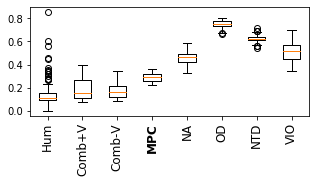

In [88]:
# draw mpc
mpc_types = []
for models in model_types:
        mpc_types.append([model.mpc for model in models])
drawBoxDiagram('MPC', rep.mpc, mpc_types, calculate_ks, 3)

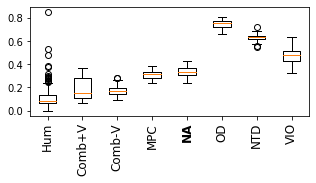

In [89]:
# draw node activity
na_types = []
for models in model_types:
        na_types.append([model.na for model in models])
drawBoxDiagram('Node_Activity', rep.na, na_types, calculate_ks, 4)

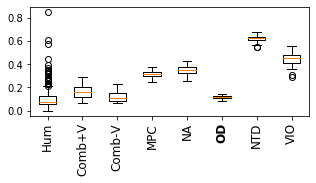

In [90]:
# draw out degree
out_d_types = []
for models in model_types:
        out_d_types.append([model.out_d for model in models])
drawBoxDiagram('Out_Degree', rep.out_d, out_d_types, calculate_ks, 5)

In [91]:
def manual_ks(pdf1, pdf2):
    result = 0
    sum1 = 0
    sum2 = 0
    for(a, b) in zip(pdf1, pdf2):
        sum1 += a
        sum2 += b
        result = max(result, abs(sum1-sum2))
    return result


['EAnnotation', 'EAttribute', 'EClass', 'EDataType', 'EEnum', 'EEnumLiteral', 'EGenericType', 'EOperation', 'EPackage', 'EParameter', 'EReference', 'ETypeParameter']


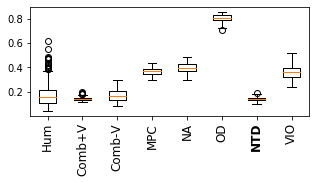

In [92]:
# draw node type
types = sorted(rep.nodeTypeStat.keys())
rep_type_dist = [float(rep.nodeTypeStat[key]) for key in types]
print(types)
node_type_types = []
for models in model_types:
    type_dists = []
    for model in models:
        type_dists.append([float(model.nodeTypeStat.get(key, 0)) for key in types])
    node_type_types.append(type_dists)

#since we already know the pdf, we can compute the ks distance manually
drawBoxDiagram('Node_Type', rep_type_dist, node_type_types, manual_ks, 6)

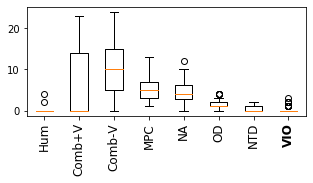

In [93]:
# draw violations
violation_types = []
for models in model_types:
        violation_types.append([model.violations for model in models])
drawBoxDiagram('Violations', None, violation_types, lambda a, b:b, 7)